# GeoPandas basics: cells and transcripts


In [ ]:
!pip install geopandas matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely import Point, Polygon
import geopandas as gpd

## About shapes (cells)

### Using lists

A cell can be represented by a polygon, which is an ordered list or vertices.

To start with a simple example, we will create a cell whose corresponding polygon has 4 vertices. Each vertex (in 2D) is represented by coordinates `(x, y)`.


In [2]:
vertex1 = [20, 100]  # coordinates (x, y)
vertex2 = [40, 120]
vertex3 = [80, 50]
vertex4 = [60, 0]

vertices = [vertex1, vertex2, vertex3, vertex4]  # list of the cell vertices

We can display these four vertices using `matplotlib`:


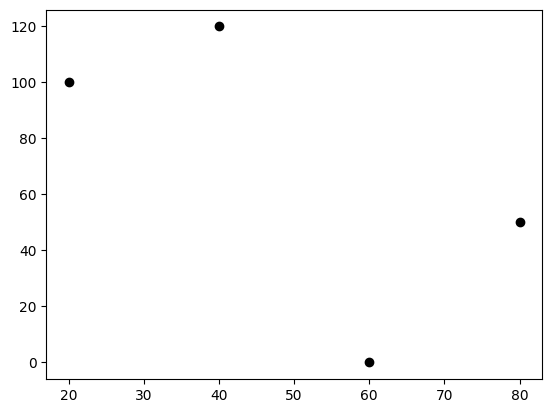

In [3]:
plt.scatter(*zip(*vertices), color="k")

We can also show the edges of the polygon.

> **_Question:_** what's the `%` sign below, and why do we need it here ?


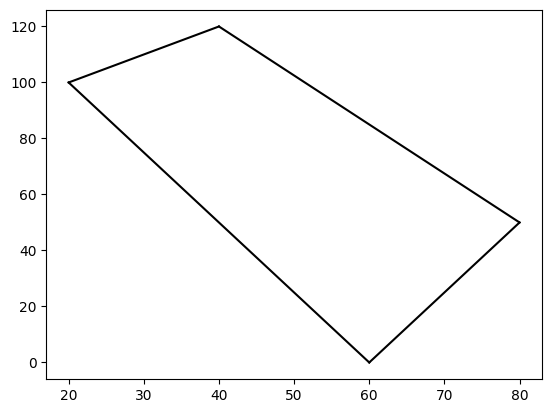

In [4]:
for i in range(len(vertices)):
    next_index = (i + 1) % len(vertices)

    # coordinates of vertex i
    (x1, y1) = vertices[i]

    # coordinates of the next vertex
    (x2, y2) = vertices[next_index]

    # we plot the line between the two vertices
    plt.plot([x1, x2], [y1, y2], color="k")

### Using `shapely`

[`shapely`](https://shapely.readthedocs.io/en/2.0.4/manual.html) is a Python libraries that performs many operations on geometries such as `Point`, `Polygon`, `Line`, or many others.

We can provide the list of vertices to `shapely`:


In [5]:
cell = Polygon(vertices)

`shapely` itself can display the cell.

> **_Question:_** Why the shape looks slightly different to the previous one?


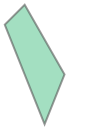

In [6]:
cell

We can easily perform some operation that would be complex to code ourself. For instance, we just need to add `.area` to compute the area of the cell:


In [7]:
cell.area

3100.0

We can also inflate the cell with `.buffer(radius)`, where `radius` is the expansion distance.


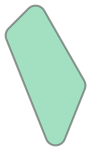

In [8]:
cell_buffer = cell.buffer(10)
cell_buffer

This cell has much more vertices (see below). This is because of the "round" angles, which require more vertices.


In [9]:
np.array(cell_buffer.exterior.coords)

array([[ 10.71523309,  96.28609324],
       [ 10.39875091,  97.20428614],
       [ 10.17283148,  98.14884931],
       [ 10.03960575,  99.11087326],
       [ 10.00033036, 100.0812838 ],
       [ 10.05537577, 101.05092764],
       [ 10.20422277, 102.01065872],
       [ 10.44546738, 102.95142448],
       [ 10.77683409, 103.86435125],
       [ 11.19519731, 104.74082794],
       [ 11.69661088, 105.57258729],
       [ 12.27634526, 106.35178381],
       [ 12.92893219, 107.07106781],
       [ 32.92893219, 127.07106781],
       [ 33.64457168, 127.72065612],
       [ 34.41957754, 128.2981254 ],
       [ 35.2467104 , 128.79808149],
       [ 36.11824397, 129.21585428],
       [ 37.02603721, 129.54754132],
       [ 37.96161037, 129.79004432],
       [ 38.91622424, 129.94109803],
       [ 39.88096171, 129.99929147],
       [ 40.84681112, 129.96408104],
       [ 41.80475042, 129.83579564],
       [ 42.74583147, 129.6156336 ],
       [ 43.66126357, 129.30565146],
       [ 44.54249563, 128.90874478],
 

If we use `buffer` with a very large radius, we can't see the initial cell shape anymore.


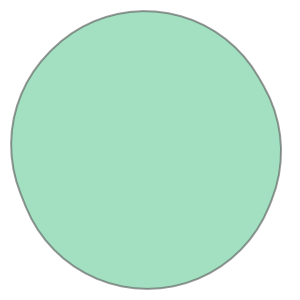

In [10]:
cell.buffer(1000)

### Rasterization

We can transform this cell into an image with values `1` where the cell is, and `0` elsewhere. We can do that with `skimage`. This type of operation is called `rasterization`.


In [11]:
from skimage import measure
from skimage.draw import polygon as skimage_polygon

> **_Question:_** Why the image seems flipped?


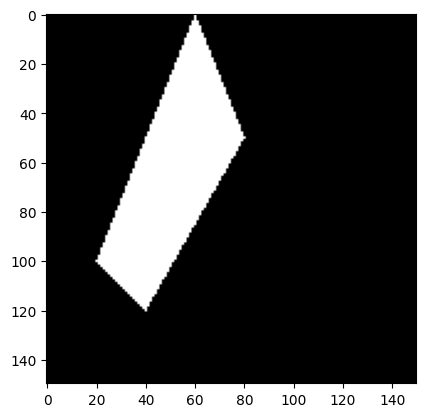

In [12]:
image_shape = (150, 150)

image = np.zeros(image_shape)

rr, cc = skimage_polygon(cell.exterior.xy[0], cell.exterior.xy[1], shape=image_shape)
image[cc, rr] = 1

plt.imshow(image, cmap="gray")

### Vectorization

We can also do the opposite, i.e. create a polygon from an image with ones and zeros. We call this operation vectorization, because we transform an image into a vector format.


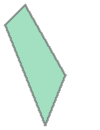

In [13]:
coords, *_ = measure.find_contours(image)
vectorized_cell = Polygon(coords[:, [1, 0]])

vectorized_cell

### About `GeoPandas`

Let's create more cells


In [14]:
cell2 = Polygon([(20, 10), (10, 60), (-20, 80), (-30, 20), (-10, -10), (0, -20)])
cell3 = Polygon(
    [(20, 90), (30, 80), (50, -20), (40, -70), (10, -80), (-10, -20), (0, 0)]
)

We can put all the cells together in the DataFrame. To do this, we use `GeoPandas`, which is an extension of `pandas` to support `shapely` geometries. In practice, we put the geometries in a `geometry` column:


In [15]:
cells = gpd.GeoDataFrame(geometry=[cell, cell2, cell3])
cells

,geometry
0,"POLYGON ((20 100, 40 120, 80 50, 60 0, 20 100))"
1,"POLYGON ((20 10, 10 60, -20 80, -30 20, -10 -1..."
2,"POLYGON ((20 90, 30 80, 50 -20, 40 -70, 10 -80..."


We can display the three cells directly with `.plot()`, and use `alpha` to set the opacity. We see that two cells overlap.

> **_Question:_** let's take a tissue section of size $(X_{max}, Y_{max}, Z_{max}) = (1cm, 1cm, 10\mu m)$. If we look at this section in 2D (seen from above, by "flattening" the `z` axis), is it possible for the cells to overlap? If so, what problems might this create?


<Axes: >

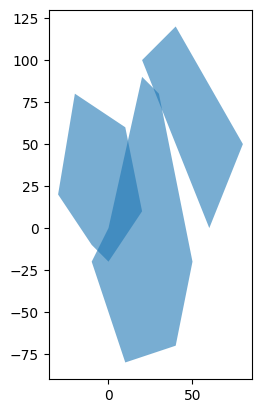

In [16]:
cells.plot(alpha=0.6)

### Adding transcripts

A transcript is represented by a 2D point `(x, y)`, and the name of the corresponding gene. This can be built with the `Point` class from `shapely`, as shown below.


In [17]:
transcript1 = Point(50, 60)
gene1 = "PTPRC"  # gene expressed on immune cells

`GeoPandas`, via `shapely`, simplifies many geometric operations. For example, with `.contains`, you can find out in which cell(s) the transcript is located. Here, it's in cell `0`.


In [18]:
cells.contains(transcript1)

0     True
1    False
2    False
dtype: bool

Let's create three more transcripts. One corresponding to the `CD3E` gene, and two to `PTPRC` (again).


In [19]:
transcript2 = Point(10, 20)
gene2 = "CD3E"

transcript3 = Point(30, 7)
gene3 = "PTPRC"

transcript4 = Point(20, -50)
gene4 = "PTPRC"

Once again, we create a `GeodataFrame`. We also add a column to store the gene name.


In [20]:
transcripts = gpd.GeoDataFrame(
    geometry=[transcript1, transcript2, transcript3, transcript4],
    data={
        "gene": [gene1, gene2, gene3, gene4],
    },
)

transcripts["gene"] = transcripts["gene"].astype("category")

transcripts

,gene,geometry
0,PTPRC,POINT (50 60)
1,CD3E,POINT (10 20)
2,PTPRC,POINT (30 7)
3,PTPRC,POINT (20 -50)


All gene names are retrieved. Note that we have four transcripts, but only two different genes (PTPRC and CD3E).


In [21]:
gene_panel = transcripts["gene"].unique()
gene_panel

['PTPRC', 'CD3E']
Categories (2, object): ['CD3E', 'PTPRC']

### Spatial join

Spatial joins allow you to perform operations for any combination of cell and transcript. For example, here we're looking for all cell-transcript pairs where the cell contains the transcript.

> **_Questions:_** What does the index (left) correspond to, and what does `index_right` correspond to? Why do we see the CD3E gene twice when it only has one transcript?


In [22]:
joined = cells.sjoin(transcripts)
joined

,geometry,index_right,gene
0,"POLYGON ((20 100, 40 120, 80 50, 60 0, 20 100))",0,PTPRC
1,"POLYGON ((20 10, 10 60, -20 80, -30 20, -10 -1...",1,CD3E
2,"POLYGON ((20 90, 30 80, 50 -20, 40 -70, 10 -80...",3,PTPRC
2,"POLYGON ((20 90, 30 80, 50 -20, 40 -70, 10 -80...",2,PTPRC
2,"POLYGON ((20 90, 30 80, 50 -20, 40 -70, 10 -80...",1,CD3E


Thanks to this spatial join, we can "aggregate" the transcripts in the cells, i.e. how many counts of each gene are in each cell. We thus have an array of size `#cells` x `#genes`.


In [23]:
cell_by_gene = np.zeros((len(cells), len(gene_panel)), dtype=int)

for cell_index, gene_index in joined.gene.cat.codes.items():
    cell_by_gene[cell_index, gene_index] += 1

cell_by_gene = pd.DataFrame(cell_by_gene, columns=joined.gene.cat.categories)
cell_by_gene

,CD3E,PTPRC
0,0,1
1,1,0
2,1,2


In this simple example, we only have two genes. To simplify things, we can add the counts to the `GeoDataFrame` of the cells. This gives us the geometry of the cells as well as their transcriptomic expression.


In [24]:
for gene in gene_panel:
    cells[gene] = cell_by_gene[gene]

cells

,geometry,PTPRC,CD3E
0,"POLYGON ((20 100, 40 120, 80 50, 60 0, 20 100))",1,0
1,"POLYGON ((20 10, 10 60, -20 80, -30 20, -10 -1...",0,1
2,"POLYGON ((20 90, 30 80, 50 -20, 40 -70, 10 -80...",2,1


We can display the cells in space, and color them by their PTPRC expression.

> **_Question:_** which cell(s) are potentially immune cells?


<Axes: >

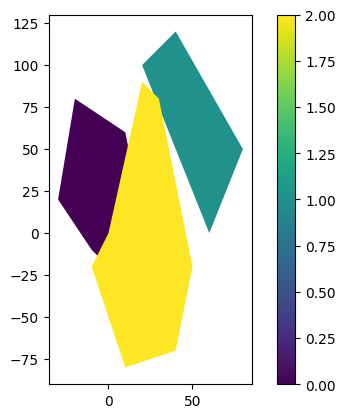

In [25]:
cells.plot(column="PTPRC", legend=True)